## 

In [53]:
from numpy import random
import pandas as pd
import pygraphviz as pgv
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


class miuPuzzle:
    
    """
    A class to represent Douglas Hofstadter's impossible MIU-puzzle and its variants
    based on a starting string (The axiom.).
    """
    
    def __init__(self, axiom):
        self.axiom = axiom


    def rule_one_possible(self, string):
        
        """
        Returns True or False depending on whether the last letter of the current
        string is 'I'.
        """
        
        if string[-1:] == 'I':
            return True  
        else:
            return False
    
    
    def rule_two_possible(self, string):
        
        """
        Returns True or False depending on whether the first letter of the current
        string is 'M'.
        """
        
        if string[:1] == 'M':
            return True
        else:
            return False
    
    
    def rule_three_possible(self, string):
        
        """
        Returns True or False depending on whether the current string contains 'III'.
        """
         
        if string.find('III') != -1:
            return True
        else:
            return False
        
    
    def rule_four_possible(self, string):
        
        """
        Returns True or False depending on whether the current string contains 'UU'.
        """
        
        if string.find('UU') != -1:
            return True
        else:
            return False    

    
    def rule_three_indices(self, string):
        
        """
        Returns list of indices, if any, at which rule three can be applied to a string,
        """
        
        return [index for index, char in enumerate(string) if string.startswith('III', index)]
     
    
    def get_options(self, string):
    
        """
        Returns dictionary of rules (values) that can be applied to the current string
        and the corresponding resultant strings (keys).
        """
        
        options = dict()
    
        if self.rule_one_possible(string):
            options[self.apply_rule_one(string)] = '1'
    
        if self.rule_two_possible(string):
            options[self.apply_rule_two(string)] = '2'
    
        # Applying rule three generally involves a for loop because it can be applied at different 
        # indices in the string. For example 'MIIIIU' can be mapped to either 'MUIU' or 'MIUU'.
        if self.rule_three_possible(string):
            for index in self.rule_three_indices(string):
                options[self.apply_rule_three(string, index)] = f'3i{index}'
            
        if self.rule_four_possible(string):
            options[self.apply_rule_four(string)] = '4'
    
        return options
    
        
    def apply_rule_one(self, string):
        
        """
        For input string of format 'xI', returns 'xIU'.
        """
        
        if self.rule_one_possible(string):
            return f'{string}U'
        else:
            return None
    
    
    def apply_rule_two(self, string):
        
        """
        For input string of format 'Mx', returns 'Mxx'.
        """
        
        if self.rule_two_possible(string):
            return f'{string}{string[1:]}'    
        else:
            return None
    
    
    def apply_rule_three(self, string, index):
        
        """
        For input string (and index) of format 'xIIIy', returns 'xUy'. 
        """
        
        if self.rule_three_possible(string):
            return f'{string[:index]}U{string[index+3:]}'
        else:
            return None
    
    
    def apply_rule_four(self, string):
        
        """
        For input string of format 'xUUy', returns 'xy'.
        """

        if self.rule_four_possible(string):
            index = string.find('UU')
            return f'{string[:index]}{string[index+2:]}'
        else:
            return None
    

    def random_traversal(self, string, num_steps):
    
        """
        Given a starting string (axiom) and a number of steps, returns a dictionary of resultant strings
        and the rules used to get those strings. Can be thought of as a random walk through the 
        directed graph of available strings (nodes) accessible by the available rules (edges).
        """

        path = dict()
        rules = [None,]
        strings = [string,]

        i=0
        while i < num_steps:

            options = self.get_options(string)

            string = random.choice(list(options.keys()))
            rule = options[string]

            strings.append(string)
            rules.append(rule)

            i+=1

        path['rules'] = rules
        path['strings'] = strings

        return path


    def discover_local_network(self, string, num_steps):
        
        """
        Given a starting string (axiom) and a maximum number of steps, returns a nested dictionary of all
        possible resultant strings (nodes) accessible by the available rules (edges).
        
        WARNING: Scales extremely poorly for num_steps > 7.
        """
        
        # collect discovered strings (nodes) in a set, starting with the axiom node 
        nodes = {string,}
        
        # collect discovered edges in a dictionary ((parent node, child node) tuple as keys, rule as values))
        edges = dict()

        i=0
        while i<num_steps:
            
            # empty list to collect nodes (strings) that are adjacent to the existing set of nodes
            new_neighbours = []
            for node in nodes:
                
                # get all accessible strings from the current string (node) and the corresponding rules
                neighbour_rule_pairs = self.get_options(node)
                

                for neighbour_rule_pair in neighbour_rule_pairs.items():

                    edges[tuple([node, neighbour_rule_pair[0]])] = neighbour_rule_pair[1]

                    new_neighbours.append(neighbour_rule_pair[0])

            for new_neighbour in new_neighbours:
                nodes.add(new_neighbour)

            i+=1

        network = dict()
        network['nodes'] = nodes
        network['edges'] = edges

        return network


    def get_adjacency_matrix(self, network):
    
        adjacency = pd.DataFrame(0, index=network['nodes'], columns=network['nodes'])
    
        for edge in network['edges'].items():
            adjacency.loc[edge[0][1], edge[0][0]] = edge[1]
        
        return adjacency


    def plot_network(self, network):
    
        plt.rcParams['figure.dpi'] = 400
        
        dag = pgv.AGraph(directed=True, overlap='false', splines='true')
        
        for node in network['nodes']:
            dag.add_node(node)
        
        for edge in network['edges'].items():
            dag.add_edge(edge[0], label=edge[1], color='red')
        
        dag.layout(prog='neato')  #neato, dot, twopi, circo, fdp, nop, wc, acyclic, gvpr, gvcolor, ccomps, sccmap, tred, sfdp, unflatten.
        dag.draw('dag.png')
        
        img = mpimg.imread('dag.png')
        plt.imshow(img)
        plt.axis('off')
        plt.show()


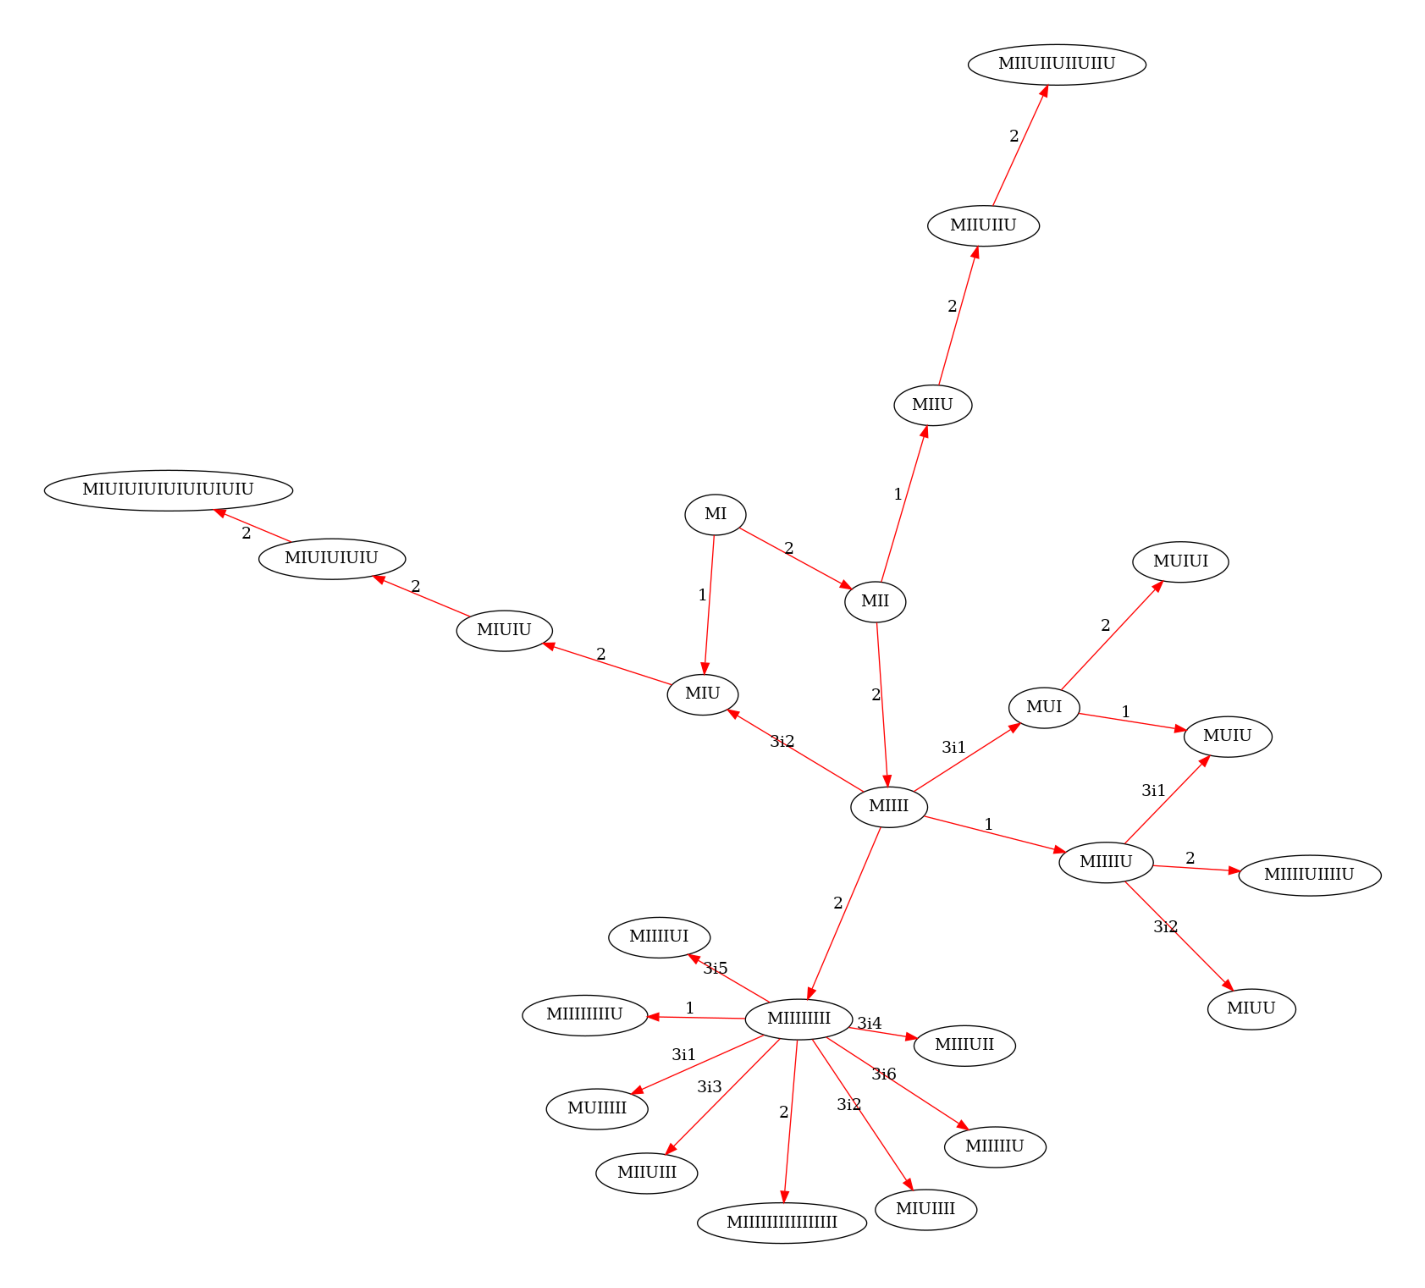

In [54]:
mi = miuPuzzle(axiom='MI')

network = mi.discover_local_network(string=mi.axiom, num_steps=4)


# sanity check
assert 'MU' not in network['nodes']

mi.plot_network(network)

In [50]:
d = dict()
d['a'] = 2
d['b'] = 3

d

{'a': 2, 'b': 3}

In [52]:
for letter, number in d.items():
    print(letter, number)

a 2
b 3
